In [ ]:
import os
import pandas as pd
pd.options.display.max_columns = None  # Show all columns
pd.options.display.width = 1000        # Adjust width to fit more data

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DecimalType, IntegerType, StringType, StructField, StructType

import warnings
warnings.simplefilter('ignore', UserWarning)

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

spark = SparkSession.builder.appName("Home Credit Default Prediction").getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled", True) 
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.conf.set("spark.sql.repl.eagerEval.maxNumCols", 200) 
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

def print_message(df):
    print ("Rows :: {}  |  Columns :: {}".format(df.count(), len(df.columns)))
    return (None)

def table_desc(name, df):
    
    df.filter(F.col('Row') == name)\
        .select('Table', 'Row', 'Description')\
        .distinct()\
        .show(10, False)
    return (None)

path = os.getcwd()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/28 09:17:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" width="800"/>

In [2]:
# Training and testing data
sdf_train = spark.read.option('header', True)\
           .csv(path + "/Data/application_train.csv")

sdf_test = spark.read.option('header', True)\
           .csv(path + "/Data/application_test.csv")

# Bureau data with previous credit history
sdf_bureau = spark.read.option('header', True)\
           .csv(path + "/Data/bureau.csv")

sdf_bureau_balance = spark.read.option('header', True)\
           .csv(path + "/Data/bureau_balance.csv")

# Previous application of the customers
sdf_prev_app = spark.read.option('header', True)\
           .csv(path + "/Data/previous_application.csv")

# Previous Home credit loan/cash loans with Home Credit
sdf_posh_cash_balance = spark.read.option('header', True)\
           .csv(path + "/Data/POS_CASH_BALANCE.csv")

# Credit Card Balance of the customers with Home Credit
sdf_cc_balance = spark.read.option('header', True)\
           .csv(path + "/Data/credit_card_balance.csv")

# previous installments by the customers
sdf_prev_installments = spark.read.option('header', True)\
           .csv(path + "/Data/installments_payments.csv")

# Column description
sdf_desc = spark.read.option('header', True)\
            .csv(path + "/Data/HomeCredit_columns_description.csv")

In [3]:
print_message(sdf_train)
print_message(sdf_test)
print_message(sdf_prev_app)
print_message(sdf_cc_balance)

Rows :: 307511  |  Columns :: 122
Rows :: 48744  |  Columns :: 121
Rows :: 1670214  |  Columns :: 37
Rows :: 3840312  |  Columns :: 23


In [4]:
sdf_posh_cash_balance.show(5, False)    

+----------+----------+--------------+--------------+---------------------+--------------------+------+----------+
|SK_ID_PREV|SK_ID_CURR|MONTHS_BALANCE|CNT_INSTALMENT|CNT_INSTALMENT_FUTURE|NAME_CONTRACT_STATUS|SK_DPD|SK_DPD_DEF|
+----------+----------+--------------+--------------+---------------------+--------------------+------+----------+
|1803195   |182943    |-31           |48.0          |45.0                 |Active              |0     |0         |
|1715348   |367990    |-33           |36.0          |35.0                 |Active              |0     |0         |
|1784872   |397406    |-32           |12.0          |9.0                  |Active              |0     |0         |
|1903291   |269225    |-35           |48.0          |42.0                 |Active              |0     |0         |
|2341044   |334279    |-35           |36.0          |35.0                 |Active              |0     |0         |
+----------+----------+--------------+--------------+---------------------+-----

In [5]:
sdf_train.show(10, False)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+-----------------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+----------------------+-------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-

In [6]:
sdf_prev_app.show(10, False)

+----------+----------+------------------+-----------+---------------+----------+----------------+---------------+--------------------------+-----------------------+---------------------------+----------------------+-----------------+---------------------+------------------------+----------------------+--------------------+-------------+---------------------+------------------+---------------+----------------+-------------------+--------------+-----------------+-----------------------+----------------+--------------------+-----------+----------------+------------------------+------------------+--------------+-------------------------+-------------+----------------+-------------------------+
|SK_ID_PREV|SK_ID_CURR|NAME_CONTRACT_TYPE|AMT_ANNUITY|AMT_APPLICATION|AMT_CREDIT|AMT_DOWN_PAYMENT|AMT_GOODS_PRICE|WEEKDAY_APPR_PROCESS_START|HOUR_APPR_PROCESS_START|FLAG_LAST_APPL_PER_CONTRACT|NFLAG_LAST_APPL_IN_DAY|RATE_DOWN_PAYMENT|RATE_INTEREST_PRIMARY|RATE_INTEREST_PRIVILEGED|NAME_CASH_LOAN_PURP

### Customer Example

In [10]:
# train data
sdf_train.filter(F.col('SK_ID_CURR') == 380361)\
            .show(20, False)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-----------------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------------+------------------+------------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+------------------

In [11]:
# prev applications
sdf_prev_app.filter(F.col('SK_ID_CURR') == 380361)\
        .sort(F.asc('DAYS_DECISION')).show(20, False)

+----------+----------+------------------+-----------+---------------+----------+----------------+---------------+--------------------------+-----------------------+---------------------------+----------------------+-------------------+---------------------+------------------------+----------------------+--------------------+-------------+---------------------+------------------+---------------+----------------+-------------------+--------------+-----------------+-----------------------+----------------+--------------------+-----------+----------------+------------------------------+------------------+--------------+-------------------------+-------------+----------------+-------------------------+
|SK_ID_PREV|SK_ID_CURR|NAME_CONTRACT_TYPE|AMT_ANNUITY|AMT_APPLICATION|AMT_CREDIT|AMT_DOWN_PAYMENT|AMT_GOODS_PRICE|WEEKDAY_APPR_PROCESS_START|HOUR_APPR_PROCESS_START|FLAG_LAST_APPL_PER_CONTRACT|NFLAG_LAST_APPL_IN_DAY|RATE_DOWN_PAYMENT  |RATE_INTEREST_PRIMARY|RATE_INTEREST_PRIVILEGED|NAME_CASH

## Preprocessing

#### Changing Data types

In [7]:
def column_descriptor(df):
    ls_num = []
    ls_string = []
    for column in list(df.columns):
        test_df = df.filter(F.col(column).isNotNull()).select(column,F.col(column).cast("int").isNotNull().alias("Value"))
        size = test_df.where(F.col("Value") == 'false').count()

        if size == 0:
            ls_num.append(column)
        else:
            ls_string.append(column)
    
    return (ls_num, ls_string)

In [8]:
ls_num, ls_string = column_descriptor(sdf_train)

# Exception for sdf_train
ls_num.append('EXT_SOURCE_2')
ls_string.remove('EXT_SOURCE_2')

for col_name in ls_num:
    sdf_train = sdf_train.withColumn(col_name, F.col(col_name).cast('float'))

# Type casting for some columns
sdf_train = sdf_train.withColumn('SK_ID_CURR', F.col('SK_ID_CURR').cast('int'))\
    .withColumn('TARGET', F.col('TARGET').cast('int'))

In [9]:
ls_num, ls_string = column_descriptor(sdf_test)

# Exception for sdf_train
ls_num.append('EXT_SOURCE_2')
ls_string.remove('EXT_SOURCE_2')

for col_name in ls_num:
    sdf_test = sdf_test.withColumn(col_name, F.col(col_name).cast('float'))

# Type casting for some columns
sdf_test = sdf_test.withColumn('SK_ID_CURR', F.col('SK_ID_CURR').cast('int'))

In [10]:
ls_num, ls_string = column_descriptor(sdf_prev_app)

# Exception for sdf_prev_app
ls_num.append('RATE_DOWN_PAYMENT')
ls_string.remove('RATE_DOWN_PAYMENT')

for col_name in ls_num:
    sdf_prev_app = sdf_prev_app.withColumn(col_name, F.col(col_name).cast('float'))

# Type casting for some columns
sdf_prev_app = sdf_prev_app.withColumn('SK_ID_CURR', F.col('SK_ID_CURR').cast('int'))\
    .withColumn('SK_ID_PREV', F.col('SK_ID_PREV').cast('int'))

In [11]:
sdf_train.show(10, False)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+-----------------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+----------------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-

####  NULLS Conversion 365243

In [12]:
def null_365243(df, ls_days):
    
    df_t = df
    for col_names_ in ls_days:
        count_ = df_t.filter(F.col(col_names_) == 365243.0).count()
        print (f'{col_names_} :: {count_}')

        if count_ > 0:
            df_t = df_t.withColumn(col_names_, F.when(F.col(col_names_) == 365243, None).otherwise(F.col(col_names_)))
            count_ = df_t.filter(F.col(col_names_) == 365243.0).count()
            print (f'{col_names_} :: {count_} :: NEW COUNT')
    return (df_t)

In [13]:
ls = list(sdf_train.columns)
ls_days_train = [col for col in ls if 'DAYS' in col]

sdf_train = null_365243(df = sdf_train, ls_days = ls_days_train)

DAYS_BIRTH :: 0
DAYS_EMPLOYED :: 55374
DAYS_EMPLOYED :: 0 :: NEW COUNT
DAYS_REGISTRATION :: 0
DAYS_ID_PUBLISH :: 0
DAYS_LAST_PHONE_CHANGE :: 0


In [14]:
ls = list(sdf_test.columns)
ls_days_test = [col for col in ls if 'DAYS' in col]

sdf_test = null_365243(df = sdf_test, ls_days = ls_days_test)

DAYS_BIRTH :: 0
DAYS_EMPLOYED :: 9274
DAYS_EMPLOYED :: 0 :: NEW COUNT
DAYS_REGISTRATION :: 0
DAYS_ID_PUBLISH :: 0
DAYS_LAST_PHONE_CHANGE :: 0


In [15]:
ls = list(sdf_prev_app.columns)
ls_days_prev = [col for col in ls if 'DAYS' in col]

sdf_prev_app = null_365243(df = sdf_prev_app, ls_days = ls_days_prev)

DAYS_DECISION :: 0
DAYS_FIRST_DRAWING :: 934444
DAYS_FIRST_DRAWING :: 0 :: NEW COUNT
DAYS_FIRST_DUE :: 40645
DAYS_FIRST_DUE :: 0 :: NEW COUNT
DAYS_LAST_DUE_1ST_VERSION :: 93864
DAYS_LAST_DUE_1ST_VERSION :: 0 :: NEW COUNT
DAYS_LAST_DUE :: 211221
DAYS_LAST_DUE :: 0 :: NEW COUNT
DAYS_TERMINATION :: 225913
DAYS_TERMINATION :: 0 :: NEW COUNT


#### Days conversion to years

In [16]:
for col_names_ele in ls_days_train:
    sdf_train = sdf_train.withColumn(col_names_ele + "_YEARS", F.round(F.abs(F.col(col_names_ele)) / 365, 2))

for col_names_ele in ls_days_train:
    sdf_test = sdf_test.withColumn(col_names_ele + "_YEARS", F.round(F.abs(F.col(col_names_ele)) / 365, 2))

In [17]:
sdf_train.select(ls_days_train + [col + "_YEARS" for col in ls_days_train]).show(10, False)

+----------+-------------+-----------------+---------------+----------------------+----------------+-------------------+-----------------------+---------------------+----------------------------+
|DAYS_BIRTH|DAYS_EMPLOYED|DAYS_REGISTRATION|DAYS_ID_PUBLISH|DAYS_LAST_PHONE_CHANGE|DAYS_BIRTH_YEARS|DAYS_EMPLOYED_YEARS|DAYS_REGISTRATION_YEARS|DAYS_ID_PUBLISH_YEARS|DAYS_LAST_PHONE_CHANGE_YEARS|
+----------+-------------+-----------------+---------------+----------------------+----------------+-------------------+-----------------------+---------------------+----------------------------+
|-9461.0   |-637.0       |-3648.0          |-2120.0        |-1134.0               |25.92           |1.75               |9.99                   |5.81                 |3.11                        |
|-16765.0  |-1188.0      |-1186.0          |-291.0         |-828.0                |45.93           |3.25               |3.25                   |0.8                  |2.27                        |
|-19046.0  |-225.0  

### EDA

In [49]:
ls_num, ls_string = column_descriptor(sdf_train)
sdf_train.select(ls_string).show(10, False)

+------------------+-----------+------------+---------------+---------------+--------------------+-----------------------------+--------------------+-----------------+---------------+--------------------------+----------------------+------------------+--------------+------------------+-------------------+
|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|NAME_TYPE_SUITE|NAME_INCOME_TYPE    |NAME_EDUCATION_TYPE          |NAME_FAMILY_STATUS  |NAME_HOUSING_TYPE|OCCUPATION_TYPE|WEEKDAY_APPR_PROCESS_START|ORGANIZATION_TYPE     |FONDKAPREMONT_MODE|HOUSETYPE_MODE|WALLSMATERIAL_MODE|EMERGENCYSTATE_MODE|
+------------------+-----------+------------+---------------+---------------+--------------------+-----------------------------+--------------------+-----------------+---------------+--------------------------+----------------------+------------------+--------------+------------------+-------------------+
|Cash loans        |M          |N           |Y              |Unaccompanied  |Wo

25/02/28 12:59:14 WARN TransportChannelHandler: Exception in connection from dyn204102.shef.ac.uk/143.167.204.102:49870
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:276)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:233)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:223)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:356)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.

In [ ]:
df_train = sdf_train.toPandas()

In [20]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_BIRTH_YEARS,DAYS_EMPLOYED_YEARS,DAYS_REGISTRATION_YEARS,DAYS_ID_PUBLISH_YEARS,DAYS_LAST_PHONE_CHANGE_YEARS
0,100002,1,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461.0,-637.0,-3648.0,-2120.0,NaN,1.0,1.0,0.0,1.0,1.0,0.0,Laborers,1.0,2.0,2.0,WEDNESDAY,10.0,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.92,1.75,9.99,5.81,3.11
1,100003,0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765.0,-1188.0,-1186.0,-291.0,NaN,1.0,1.0,0.0,1.0,1.0,0.0,Core staff,2.0,1.0,1.0,MONDAY,11.0,0.0,0.0,0.0,0.0,0.0,0.0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.93,3.25,3.25,0.80,2.27
2,100004,0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Wo

TARGET
0    282686
1     24825
Name: count, dtype: int64

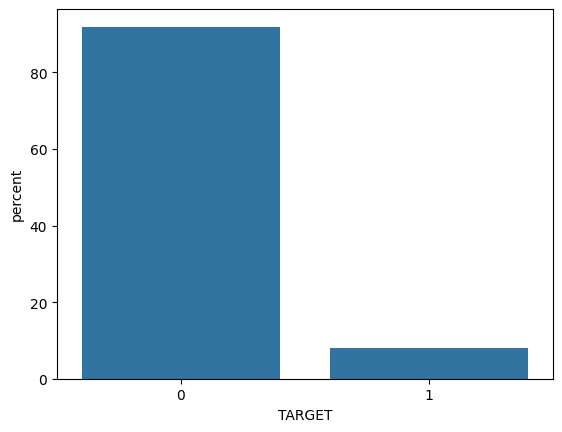

In [46]:
sns.countplot(df_train, x = 'TARGET', stat = 'percent')
df_train['TARGET'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

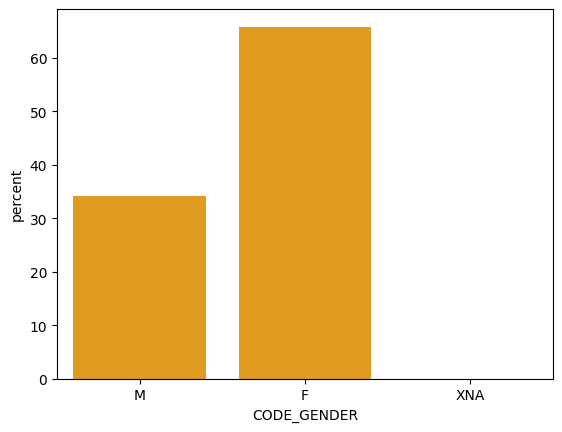

In [47]:
sns.countplot(df_train, x = 'CODE_GENDER', stat = 'percent', color = 'orange')
df_train['CODE_GENDER'].value_counts()

In [48]:
df_train.loc[df_train['CODE_GENDER'] == 'XNA', ].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_BIRTH_YEARS,DAYS_EMPLOYED_YEARS,DAYS_REGISTRATION_YEARS,DAYS_ID_PUBLISH_YEARS,DAYS_LAST_PHONE_CHANGE_YEARS
35657,141289,0,Revolving loans,XNA,Y,Y,0.0,207000.0,382500.0,19125.0,337500.0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.020713,-20232.0,-10044.0,-10024.0,-3537.0,13.0,1.0,1.0,1.0,1.0,1.0,0.0,None,2.0,3.0,3.0,TUESDAY,10.0,0.0,0.0,0.0,0.0,0.0,0.0,Business Entity Type 1,NaN,0.295998,0.461482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,-286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55.43,27.52,27.46,9.69,0.78
38566,144669,0,Revolving loans,XNA,N,Y,2.0,157500.0,270000.0,13500.0,225000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13717.0,-2797.0,-2241.0,-4659.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,Low-skill Laborers,4.0,2.0,2.0,FRIDAY,16.0,0.0,0.0,0.0,0.0,0.0,0.0,Industry: type 3,NaN,0.709205,0.310818,0.0165,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0233,NaN,0.0115,NaN,0.0000,0.0168,0.0382,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0238,NaN,0.0120,NaN,0.0000,0.0167,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0237,NaN,0.0117,NaN,0.000,None,block of flats,0.0090,"Stone, brick",No,0.0,0.0,0.0,0.0,-493.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,37.58,7.66,6.14,12.76,1.35
83382,196708,0,Revolving loans,XNA,N,Y,1.0,135000.0,405000.0,20250.0,225000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.035792,-10647.0,-1228.0,-183.0,-1671.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,Core staff,3.0,2.0,2.0,THURSDAY,15

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

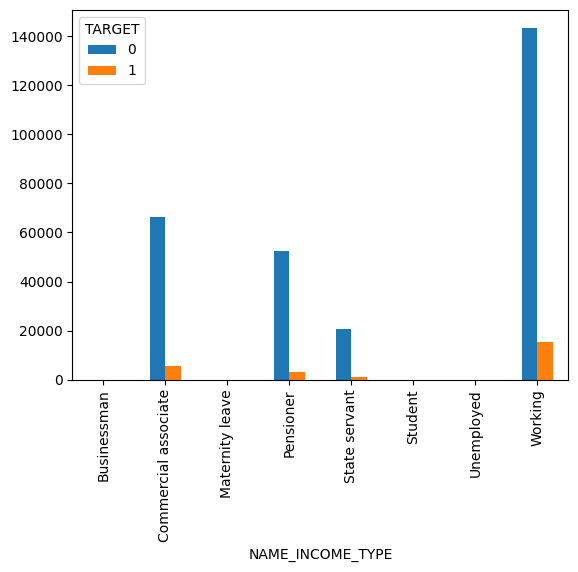

In [41]:
# sns.countplot(df_train, x = 'TARGET', stat = 'percent', hue = 'NAME_INCOME_TYPE')
df_train.groupby(['NAME_INCOME_TYPE', 'TARGET']).size().unstack().plot(kind = 'bar', stacked = False)
df_train['NAME_INCOME_TYPE'].value_counts()

In [45]:
df_train.loc[df_train['NAME_INCOME_TYPE'].isin(['Unemployed', 'Student', 'Businessman', 'Maternity leave'])].groupby(['NAME_INCOME_TYPE', 'TARGET']).size()

NAME_INCOME_TYPE  TARGET
Businessman       0         10
Maternity leave   0          3
                  1          2
Student           0         18
Unemployed        0         14
                  1          8
dtype: int64

count    307511.000000
mean         43.936976
std          11.956135
min          20.520000
25%          34.010000
50%          43.150000
75%          53.920000
max          69.120000
Name: DAYS_BIRTH_YEARS, dtype: float64


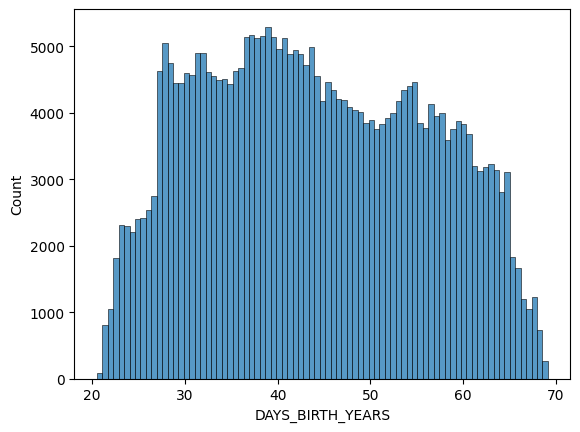

In [27]:
sns.histplot(df_train, x = 'DAYS_BIRTH_YEARS')
print (df_train['DAYS_BIRTH_YEARS'].describe())

<Axes: xlabel='OWN_CAR_AGE', ylabel='OCCUPATION_TYPE'>

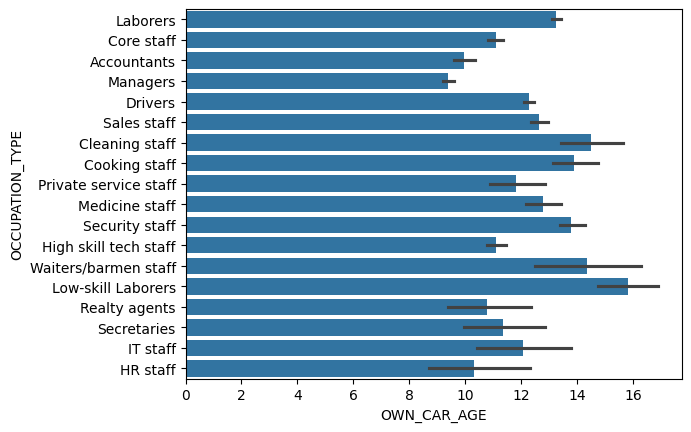

In [30]:
sns.barplot(data = df_train, x = 'OWN_CAR_AGE', y = 'OCCUPATION_TYPE')

In [54]:
sdf_train.filter(F.col('DAYS_BIRTH') == 365243.0).count()

0

In [43]:
ls = list(sdf_prev_app.columns)
ls_days = [col for col in ls if 'DAYS' in col]
ls_days

['DAYS_DECISION',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION']

In [46]:
sdf_prev_app.select('DAYS_FIRST_DRAWING').distinct().show(10, False)

+------------------+
|DAYS_FIRST_DRAWING|
+------------------+
|-184.0            |
|-64.0             |
|-2826.0           |
|-2701.0           |
|-633.0            |
|-2162.0           |
|-2307.0           |
|-1814.0           |
|-798.0            |
|-530.0            |
+------------------+
only showing top 10 rows



In [44]:
sdf_prev_app.select(ls_days).show(10, False)

+-------------+------------------+--------------+-------------------------+-------------+----------------+
|DAYS_DECISION|DAYS_FIRST_DRAWING|DAYS_FIRST_DUE|DAYS_LAST_DUE_1ST_VERSION|DAYS_LAST_DUE|DAYS_TERMINATION|
+-------------+------------------+--------------+-------------------------+-------------+----------------+
|-73.0        |365243.0          |-42.0         |300.0                    |-42.0        |-37.0           |
|-164.0       |365243.0          |-134.0        |916.0                    |365243.0     |365243.0        |
|-301.0       |365243.0          |-271.0        |59.0                     |365243.0     |365243.0        |
|-512.0       |365243.0          |-482.0        |-152.0                   |-182.0       |-177.0          |
|-781.0       |NULL              |NULL          |NULL                     |NULL         |NULL            |
|-684.0       |365243.0          |-654.0        |-144.0                   |-144.0       |-137.0          |
|-14.0        |NULL              |NUL

In [33]:
sdf_train.select('DAYS_BIRTH').show(10, False)

+----------+
|DAYS_BIRTH|
+----------+
|-9461.0   |
|-16765.0  |
|-19046.0  |
|-19005.0  |
|-19932.0  |
|-16941.0  |
|-13778.0  |
|-18850.0  |
|-20099.0  |
|-14469.0  |
+----------+
only showing top 10 rows



In [ ]:
SK_ID_CURR, SK_ID_PREV

In [81]:
sdf_prev_app.withColumn('RATE_DOWN_PAYMENT', sdf_prev_app.RATE_DOWN_PAYMENT.cast(DecimalType(18, 2))).select('RATE_DOWN_PAYMENT').show(10, False)

+-----------------+
|RATE_DOWN_PAYMENT|
+-----------------+
|0.00             |
|NULL             |
|NULL             |
|NULL             |
|NULL             |
|NULL             |
|NULL             |
|NULL             |
|NULL             |
|NULL             |
+-----------------+
only showing top 10 rows



In [67]:
test_df = sdf_prev_app.filter(F.col("RATE_DOWN_PAYMENT").isNotNull()).select("RATE_DOWN_PAYMENT",F.col("RATE_DOWN_PAYMENT").cast("int").isNotNull().alias("Value"))

In [69]:
test_df.where(F.col("Value") == 'false').show(10, False)

+----------------------+-----+
|RATE_DOWN_PAYMENT     |Value|
+----------------------+-----+
|2.4141471028544085e-05|false|
|6.6415676760777705e-06|false|
|4.471512536704676e-05 |false|
|9.101122741917918e-05 |false|
|3.0140058183562517e-05|false|
|1.4677181638086176e-05|false|
|4.3805246635076936e-05|false|
|3.762526119240772e-05 |false|
|6.451100469966441e-05 |false|
|3.797602489831247e-05 |false|
+----------------------+-----+
only showing top 10 rows



In [39]:
test = sdf_prev_app.select("HOUR_APPR_PROCESS_START",F.col("HOUR_APPR_PROCESS_START").cast("int").isNotNull().alias("Value"))

In [45]:
number = test.where(F.col("Value") == 'true').count()

In [47]:
type(number)

int

In [37]:
sum(test.select('Value').toPandas().Value)

1670214

In [19]:
sdf_prev_app.select('HOUR_APPR_PROCESS_START').to_series().isnumeric()

AttributeError: 'DataFrame' object has no attribute 'to_series'

In [14]:
ls = sdf_bureau.filter(F.col('SK_ID_CURR') == 380361).select('SK_ID_BUREAU').rdd.flatMap(lambda x: x).collect()
print (ls)

['5715448', '5715449', '5715451', '5715452', '5715453', '5715454', '5715455', '5715456', '5715457', '5715458', '5715459', '5715460', '5715461', '5180513', '5715447', '5715450', '5715462']


In [15]:
sdf_bureau_balance.filter(F.col('SK_ID_BUREAU').isin(ls))\
            .sort(F.asc('SK_ID_BUREAU'))\
            .show(20, False)

+------------+--------------+------+
|SK_ID_BUREAU|MONTHS_BALANCE|STATUS|
+------------+--------------+------+
|5180513     |-7            |C     |
|5180513     |-8            |C     |
|5180513     |-9            |C     |
|5180513     |-10           |C     |
|5180513     |-11           |C     |
|5180513     |-12           |C     |
|5180513     |-13           |C     |
|5180513     |-14           |C     |
|5180513     |-15           |C     |
|5180513     |-16           |C     |
|5180513     |-17           |C     |
|5180513     |-18           |C     |
|5180513     |-19           |C     |
|5180513     |-20           |C     |
|5180513     |-21           |C     |
|5180513     |-22           |C     |
|5180513     |-23           |C     |
|5180513     |-24           |C     |
|5180513     |-25           |C     |
|5180513     |-26           |C     |
+------------+--------------+------+
only showing top 20 rows



In [16]:
sdf_prev_app.filter(F.col('SK_ID_CURR') == 380361)\
            .sort(F.col('AMT_CREDIT'))\
            .show(20, False)

+----------+----------+------------------+-----------+---------------+----------+----------------+---------------+--------------------------+-----------------------+---------------------------+----------------------+-------------------+---------------------+------------------------+----------------------+--------------------+-------------+---------------------+------------------+---------------+----------------+-------------------+--------------+-----------------+-----------------------+----------------+--------------------+-----------+----------------+------------------------------+------------------+--------------+-------------------------+-------------+----------------+-------------------------+
|SK_ID_PREV|SK_ID_CURR|NAME_CONTRACT_TYPE|AMT_ANNUITY|AMT_APPLICATION|AMT_CREDIT|AMT_DOWN_PAYMENT|AMT_GOODS_PRICE|WEEKDAY_APPR_PROCESS_START|HOUR_APPR_PROCESS_START|FLAG_LAST_APPL_PER_CONTRACT|NFLAG_LAST_APPL_IN_DAY|RATE_DOWN_PAYMENT  |RATE_INTEREST_PRIMARY|RATE_INTEREST_PRIVILEGED|NAME_CASH

In [17]:
sdf_posh_cash_balance.filter(F.col('SK_ID_CURR') == 380361)\
                    .sort(F.col('MONTHS_BALANCE'))\
                    .show(20, False)

+----------+----------+--------------+--------------+---------------------+--------------------+------+----------+
|SK_ID_PREV|SK_ID_CURR|MONTHS_BALANCE|CNT_INSTALMENT|CNT_INSTALMENT_FUTURE|NAME_CONTRACT_STATUS|SK_DPD|SK_DPD_DEF|
+----------+----------+--------------+--------------+---------------------+--------------------+------+----------+
|2837103   |380361    |-1            |24.0          |22.0                 |Active              |0     |0         |
|1910156   |380361    |-10           |24.0          |18.0                 |Active              |0     |0         |
|1910156   |380361    |-11           |24.0          |19.0                 |Active              |0     |0         |
|1910156   |380361    |-12           |24.0          |20.0                 |Active              |0     |0         |
|1910156   |380361    |-13           |24.0          |21.0                 |Active              |0     |0         |
|1910156   |380361    |-14           |24.0          |22.0                 |Activ

In [18]:
sdf_cc_balance.filter(F.col('SK_ID_CURR') == 380361)\
            .sort(F.col('MONTHS_BALANCE'))\
            .show(20, False)

+----------+----------+--------------+-----------+-----------------------+------------------------+--------------------+--------------------------+------------------------+-----------------------+-------------------+-------------------------+------------------------+-------------+--------------------+------------------------+--------------------+--------------------------+------------------------+-------------------------+--------------------+------+----------+
|SK_ID_PREV|SK_ID_CURR|MONTHS_BALANCE|AMT_BALANCE|AMT_CREDIT_LIMIT_ACTUAL|AMT_DRAWINGS_ATM_CURRENT|AMT_DRAWINGS_CURRENT|AMT_DRAWINGS_OTHER_CURRENT|AMT_DRAWINGS_POS_CURRENT|AMT_INST_MIN_REGULARITY|AMT_PAYMENT_CURRENT|AMT_PAYMENT_TOTAL_CURRENT|AMT_RECEIVABLE_PRINCIPAL|AMT_RECIVABLE|AMT_TOTAL_RECEIVABLE|CNT_DRAWINGS_ATM_CURRENT|CNT_DRAWINGS_CURRENT|CNT_DRAWINGS_OTHER_CURRENT|CNT_DRAWINGS_POS_CURRENT|CNT_INSTALMENT_MATURE_CUM|NAME_CONTRACT_STATUS|SK_DPD|SK_DPD_DEF|
+----------+----------+--------------+-----------+------------------

In [19]:
sdf_prev_installments.filter(F.col('SK_ID_CURR') == 380361)\
                    .sort(F.col('DAYS_ENTRY_PAYMENT'))\
                    .show(20, False)

+----------+----------+----------------------+---------------------+---------------+------------------+--------------+-----------+
|SK_ID_PREV|SK_ID_CURR|NUM_INSTALMENT_VERSION|NUM_INSTALMENT_NUMBER|DAYS_INSTALMENT|DAYS_ENTRY_PAYMENT|AMT_INSTALMENT|AMT_PAYMENT|
+----------+----------+----------------------+---------------------+---------------+------------------+--------------+-----------+
|2104755   |380361    |0.0                   |30                   |-125.0         |-125.0            |357.48        |357.48     |
|2104755   |380361    |0.0                   |29                   |-156.0         |-156.0            |357.48        |357.48     |
|2653129   |380361    |1.0                   |24                   |-1599.0        |-1624.0           |25430.04      |25430.04   |
|2653129   |380361    |1.0                   |23                   |-1629.0        |-1636.0           |26242.425     |26242.425  |
|2653129   |380361    |1.0                   |22                   |-1659.0        

## Preprocessing and finding out

In [20]:
sdf_train.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in sdf_train.columns]).show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+----

In [21]:
sdf_train.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in sdf_train.columns]).show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+----

In [22]:
sdf_bureau.filter(F.col('SK_ID_CURR') == 215354).select('AMT_ANNUITY', 'SK_ID_CURR').show(20, False)

+-----------+----------+
|AMT_ANNUITY|SK_ID_CURR|
+-----------+----------+
|NULL       |215354    |
|NULL       |215354    |
|NULL       |215354    |
|NULL       |215354    |
|NULL       |215354    |
|NULL       |215354    |
|NULL       |215354    |
|NULL       |215354    |
|NULL       |215354    |
|NULL       |215354    |
|NULL       |215354    |
+-----------+----------+



In [23]:
sdf_train.filter(F.col('SK_ID_CURR') == 215354).select('AMT_ANNUITY', 'SK_ID_CURR').show(20, False)

+-----------+----------+
|AMT_ANNUITY|SK_ID_CURR|
+-----------+----------+
|21181.5    |215354    |
+-----------+----------+



In [24]:
sdf_bureau.select('CREDIT_CURRENCY').distinct().show(10, False)

+---------------+
|CREDIT_CURRENCY|
+---------------+
|currency 2     |
|currency 1     |
|currency 4     |
|currency 3     |
+---------------+



In [25]:
sdf_train.filter(F.col('SK_ID_CURR') == 215354).show(10, False)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------------+-----------------+------------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----

In [26]:
for i in sdf_train.columns:
    for j in sdf_bureau.columns:
        if (i == j):
            print (i)

SK_ID_CURR
AMT_ANNUITY


In [27]:
type(sdf_train.columns)

list

In [28]:
sdf_train.count()

307511

In [29]:
sdf_bureau.count()

1716428

In [30]:
len(sdf_train.columns)

122